# 探索的データ分析

データを料理する前に、どのようなデータが与えられているのか確認することが大切です。この段階を踏むことで、データに対する理解が深まり、より良いモデルの構築に繋がる可能性もあります。こうした一連の作業は探索的データ分析 (Exploratory Data Analysis: EDA)と呼ばれます。この作業には、データの集計、要約、可視化が含まれます。

EDAがデータ分析の作業において早期段階で行われるのは、データの異常（思い込みとの比較を含めて）や特徴を把握するためです。これらは分析全体のアプローチや良い出発点を見つけるために有効です。出発点と表現したのは、モデルの構築や特徴量の生成によって改めてデータを見つめ直す作業が発生するためです。そのため必ずしも徹底的である必要はありません。

前章でもデータについて簡単な調査を行いましたが、データをグラフによって表現してみましょう。グラフにすることで、集計値では見えなかった情報やデータ間の関係を表現できます。

特に欠損値や異常値（外れ値）、データの分布などデータ全体あるいはデータ間の関係性やそのばらつきを見るのに可視化は重要です。なお欠損値の視覚化については別の章で解説します。

## データを眺める

目的変数として設定する地価価格に影響を及ぼす変数を明らかにしたい、またその関係を知りたいという状況を設定します。

<!-- ここで扱うデータは地価公示データのみ。他のデータ、地価公示データの紹介は別のノート (`dataset/`)で。基本的に説明は地価公示データベース。データの性質に合わせて利用する。 -->

- サイズ（列数、行数）
- 各列のデータ型
- 完全データ、欠損データ

データを手に入れたら、分析作業へ取り掛かる前にまずはデータを眺めてみることにしましょう。眺める、と言ってもデータの値を1つずつ見ていくわけではありません。これから扱うデータにはどのような値が含まれているのか、データ型が処理されているか、また全体の大きさはどれくらいなのか欠損はどれだけあるかと言った情報を俯瞰的に整理していきます。

In [ ]:
source(here::here("R/setup.R"))

### データの大きさ

データフレームは行と列からなります。いくつかの関数を使って読み込んだデータの大きさを調べてみましょう。

In [3]:
dim(df_lp_kanto)

[1] 7961   40

`dim()`をデータフレームに適用すると、そのサイズを数値ベクトルで返します。最初の要素が行数、2番目の数字が列数を示します。これは次の`ncol()`、`nrow()`により個別に求めることができます。


In [4]:
nrow(df_lp_kanto)
ncol(df_lp_kanto)

[1] 7961

[1] 40

### データの一部を表示

データフレームの一部を表示して、列名と値の確認をしてみましょう。`head()`をデータフレームに対して実行すると先頭の数行を表示します。また`tail()` でデータフレームの最後の行を表示できます。いずれの関数も引数`n = ` に実数を与えることで表示される行数を制御可能です。

In [5]:
head(df_lp_kanto)

tail(df_lp_kanto, n = 3)

.row_id,prefecture,administrative_area_code,posted_land_price,name_of_nearest_station,distance_from_station,acreage,current_use,building_structure,attribute_change_supplied_facility,⋯,attribute_change_distance_from_station,attribute_change_use_district,attribute_change_fire_area,attribute_change_urban_planning_area,attribute_change_forest_law,attribute_change_parks_law,attribute_change_building_coverage,common_surveyed_position,.longitude,.latitude
<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<lgl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>
11955,群馬県,10426,39000,長野原草津口,13000,166,住宅,W2,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,138.5921,36.61913
11956,群馬県,10426,56800,長野原草津口,13000,226,店舗,W1,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,138.5933,36.62025
11965,群馬県,10426,29800,長野原草津口,14000,173,住宅,W2,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,138.6083,36.62088
12079,群馬県,10211,24900,西松井田,950,112,"住宅,店舗",W2,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,138.7953,36.31541
12086,群馬県,10211,20500,松井田,750,264,住宅,W2,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,138.8013,36.31065
12103,群馬県,10429,13300,群馬原町,1400,329,住宅,W2,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,138.8224,36.56371


.row_id,prefecture,administrative_area_code,posted_land_price,name_of_nearest_station,distance_from_station,acreage,current_use,building_structure,attribute_change_supplied_facility,⋯,attribute_change_distance_from_station,attribute_change_use_district,attribute_change_fire_area,attribute_change_urban_planning_area,attribute_change_forest_law,attribute_change_parks_law,attribute_change_building_coverage,common_surveyed_position,.longitude,.latitude
<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<lgl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>
21343,茨城県,08232,15600,銚子,3200,125,住宅,W2,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,140.8311,35.74772
21363,千葉県,12202,41200,銚子,1800,119,"住宅,店舗",S3,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,140.8434,35.73295
21375,千葉県,12202,31500,銚子,2200,111,住宅,W2,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,140.8480,35.73405


### 各列の情報

データ型や件数、欠損の状況を調べます。

In [6]:
glimpse(df_lp_kanto)

Observations: 7,961
Variables: 40
$ .row_id                                <int> 11955, 11956, 11965, 12079, 1…
$ prefecture                             <chr> "群馬県", "群馬県", "群馬県", "群馬県", "…
$ administrative_area_code               <chr> "10426", "10426", "10426", "1…
$ posted_land_price                      <int> 39000, 56800, 29800, 24900, 2…
$ name_of_nearest_station                <chr> "長野原草津口", "長野原草津口", "長野原草津口",…
$ distance_from_station                  <int> 13000, 13000, 14000, 950, 750…
$ acreage                                <int> 166, 226, 173, 112, 264, 329,…
$ current_use                            <chr> "住宅", "店舗", "住宅", "住宅,店舗", "住…
$ building_structure                     <chr> "W2", "W1", "W2", "W2", "W2",…
$ attribute_change_supplied_facility     <lgl> FALSE, FALSE, FALSE, FALSE, F…
$ water_facility                         <lgl> TRUE, TRUE, TRUE, TRUE, TRUE,…
$ gas_facility                           <lgl> FALSE, FALSE, FALSE, FALSE, F…
$ sewage_facility             

この地価公示データには45の列（変数）があります。

- データの型 (`character`, `numeric`, `logical`, `factor`)
- 欠損数、ユニーク数
- 文字データの長さの幅
- カテゴリデータの偏り、水準、順序
- 数値データの要約統計量、分布（ヒストグラム）

- `configuration`や`fire_area`は欠損を多く含んでいることがわかります。`building_structure`にもわずかですが欠損データがあります


In [ ]:
# 同一のデータで重複があるもの
df_lp_kanto %>% 
  tidyr::separate_rows("current_use", sep = ",") %>% 
  count(.row_id) %>% 
  filter(n > 1) %>% 
  distinct(.row_id) %>% 
  nrow() %>% 
  ensure(. == 1986L)

明確な答えがあるわけではありませんが、以下の情報はデータ全体、各変数について把握しておくと良いでしょう。またデータの偏りや出現傾向、分布のパターンは可視化を行い確認するのが効率的です。

## 要約統計量の算出

In [8]:
summary(df_lp_kanto)

    .row_id       prefecture        administrative_area_code posted_land_price 
 Min.   :11955   Length:7961        Length:7961              Min.   :    5660  
 1st Qu.:14496   Class :character   Class :character         1st Qu.:   74500  
 Median :16488   Mode  :character   Mode  :character         Median :  167000  
 Mean   :16531                                               Mean   :  440857  
 3rd Qu.:18518                                               3rd Qu.:  323000  
 Max.   :21375                                               Max.   :55500000  
 name_of_nearest_station distance_from_station    acreage        
 Length:7961             Min.   :    0         Min.   :    46.0  
 Class :character        1st Qu.:  500         1st Qu.:   136.0  
 Mode  :character        Median :  900         Median :   176.0  
                         Mean   : 1394         Mean   :   748.1  
                         3rd Qu.: 1700         3rd Qu.:   249.0  
                         Max.   :24000      

Rの組み込み関数として用意されている `summary()` を利用して、データフレームに含まれる列の要約統計量を得ることができます。

In [9]:
# 論理値型で標準偏差0の列を特定 constant cols
df_lp_kanto %>% 
  select(-starts_with(".")) %>% 
  select_if(is.logical) %>% 
  mutate_all(as.numeric) %>% 
  summarise_all(sd) %>% 
  tidyr::gather()

key,value
<chr>,<dbl>
attribute_change_supplied_facility,0.07414234
water_facility,0.03168620
gas_facility,0.38082955
sewage_facility,0.21241222
attribute_change_floor_area_ratio,0.01584907
attribute_change_address,0.08791066
attribute_change_acreage,0.05249935
attribute_change_current_use,0.09532450
attribute_change_building_structure,0.09203122


ここでは `skimr::` で行う例を示します。

In [10]:
# skimr::skim(df_lp) # Rコンソールでの実行は skim() で構いません
df_lp_kanto %>% 
  select(-starts_with(".")) %>% 
  skimr::skim_to_list()

variable,missing,complete,n,min,max,empty,n_unique
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
administrative_area_code,0,7961,7961,5,5,0,317
attribute_change_selected_land_status,0,7961,7961,1,1,0,3
building_structure,189,7772,7961,2,8,0,130
configuration,7087,874,7961,2,3,0,2
current_use,0,7961,7961,2,14,0,69
fire_area,4344,3617,7961,2,2,0,2
name_of_nearest_station,0,7961,7961,1,14,0,1424
prefecture,0,7961,7961,3,4,0,7
surrounding_present_usage,0,7961,7961,15,22,0,4047


論理型データのうち、`attribute_change_forest_law` と `attribute_change_parks_law` は FALSE のみが出現していることがわかります。

## 探索的データ分析

モデリングでは、目的変数の挙動（予測、分類）を明らかにすることがゴールとして設定されます。変数が多いデータであるほど確認する図の数が多くなり、効率的ではなくなります。そのため、まずはモデリングの目的変数となるデータを詳しく見ることを勧めます。また、この段階で作る図は初期モデルを構築する前段階で示唆を提供するものであると望ましいです。そこで目的変数に影響する説明変数、説明変数間の関係を明らかにすることで、次のモデリングプロセスに活かせる知識を得られることが期待できます。

探索的データ分析の結果が最終的な成果物になることは稀です。ここで作られる図は論文や書籍、プレゼンテーションのための図ではありません。つまり複雑な図を作ることは求められていません。ここでは主にggplot2による作図を行いますが、扱いに慣れた最低限の機能を提供しれくれるライブラリを利用すると良いでしょう。

以下では引き続き、地価公示データを使います。このデータには位置情報も含まれているため、地図上へのデータのマッピングも試みます。

また時系列データの例としてビールへの支出データも利用します。


## 数値データ

In [11]:
df_is_num <- 
  df_lp_kanto %>% 
  select(-starts_with(".")) %>% 
  select_if(is_numeric)

Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning message:
“Deprecated”Warning messag

## カテゴリデータ

In [ ]:
df_is_cat <- 
  df_lp_kanto %>% 
  select(-starts_with(".")) %>% 
  select_if(is.character) %>% 
  verify(ncol(.) == 13)

In [13]:
df_is_cat %>% 
  count(name_of_nearest_station, sort = TRUE)

name_of_nearest_station,n
<chr>,<int>
本厚木,54
平塚,49
宇都宮,48
水戸,48
八王子,47
川崎,40
柏,40
木更津,34
千葉,33


## 論理値

In [14]:
df_is_log <-
  df_lp_kanto %>% 
  select(-starts_with(".")) %>% 
  select_if(is.logical) %>% 
  verify(ncol(.) == 17)

In [15]:
gg_count_var <- function(data, var) {
  var <- rlang::enquo(var)
  var_label <- rlang::quo_name(var)
  data %>% 
    count(!!var) %>% 
    ggplot(aes(forcats::fct_reorder(!!var, n), n)) +
    geom_bar(stat = "identity") +
    labs(x = var_label) +
    coord_flip()
}

In [1]:
df_is_cat %>% 
  filter(stringr::str_detect(administrative_area_code, "^08")) %>% 
  gg_count_var(name_of_nearest_station)

ERROR: Error in df_is_cat %>% filter(stringr::str_detect(administrative_area_code, : could not find function "%>%"


In [ ]:
purrr::map(
  rlang::syms(names(df_is_cat)),
  ~ gg_count_var(df_is_cat %>% 
                     filter(stringr::str_detect(administrative_area_code, "^08")), 
                 !!.x))

### 全体

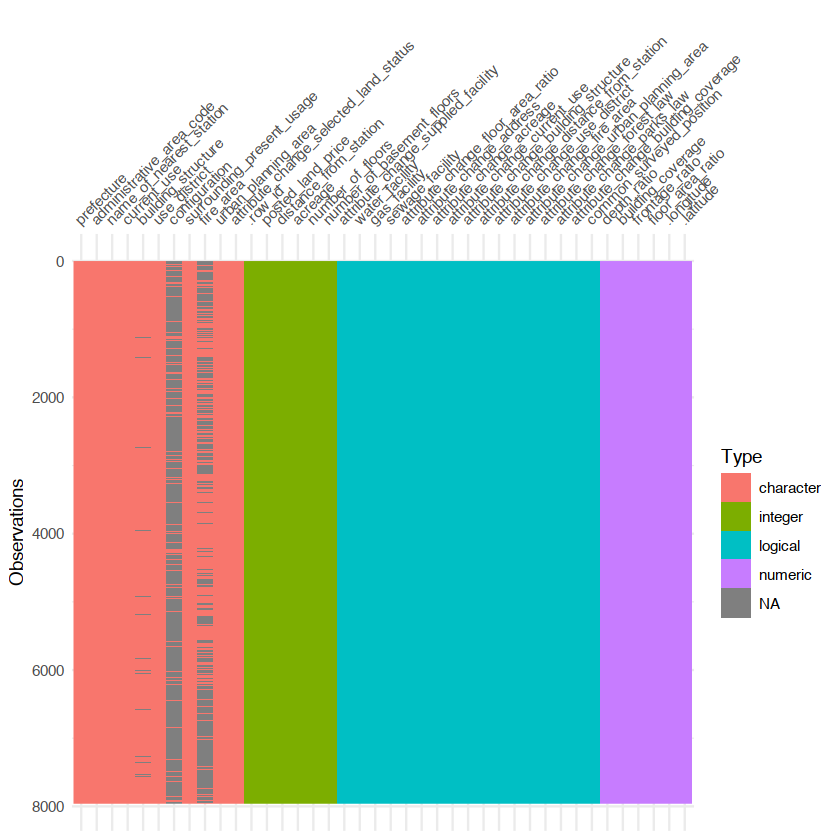

In [17]:
vis_dat(df_lp_kanto)

### 1変数の可視化

データのばらつきを見るのにはヒストグラム、箱ひげ図を利用します。一変量を対象とした単純な可視化は、変数の変動、特性を理解するのに役立ちます。

#### ヒストグラム

スパイク（峰）を検出するのに効果的です。ヒストグラムは単峰、二峰など多様な形状を取り得ます。

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

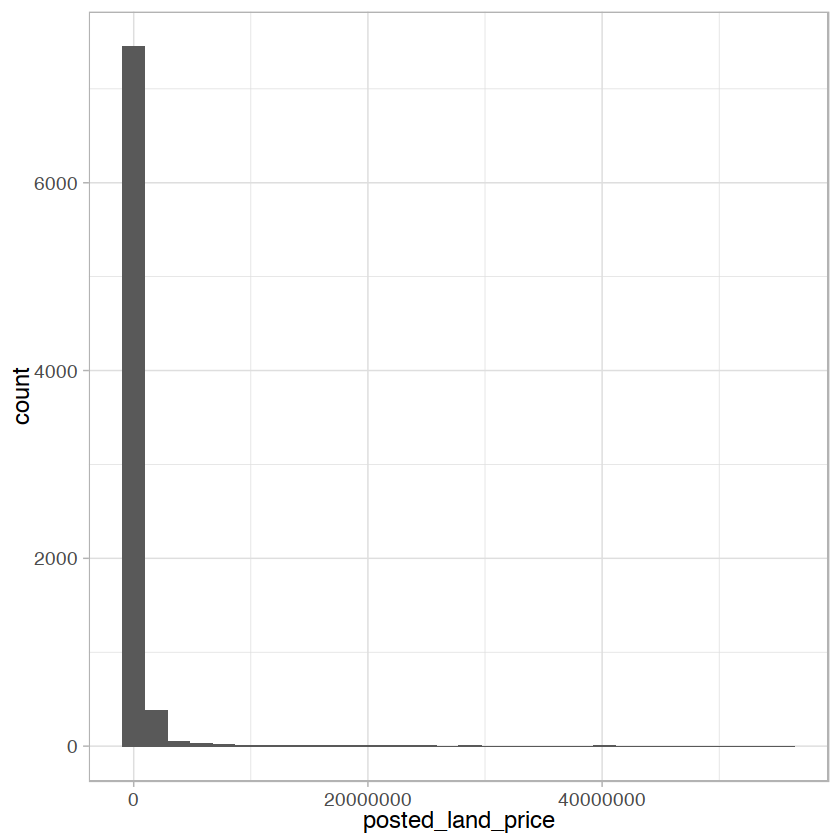

In [18]:
df_lp_kanto %>% 
  ggplot(aes(posted_land_price)) +
  geom_histogram(bins = 30)

<!-- box-cox変換をする図をあとで -->

In [ ]:
df_lp_kanto %>% 
  ggplot(aes(posted_land_price)) +
  geom_density() +
  facet_wrap(~ .prefecture, ncol = 1)

In [ ]:
library(ggridges)

ggplot(df_lp_kanto, 
       aes(x = posted_land_price, y  = .prefecture)) +
  scale_x_log10() +
  ggridges::geom_density_ridges(scale = 4)

#### 箱ひげ図・バイオリンプロット

### 2変数の可視化


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphi

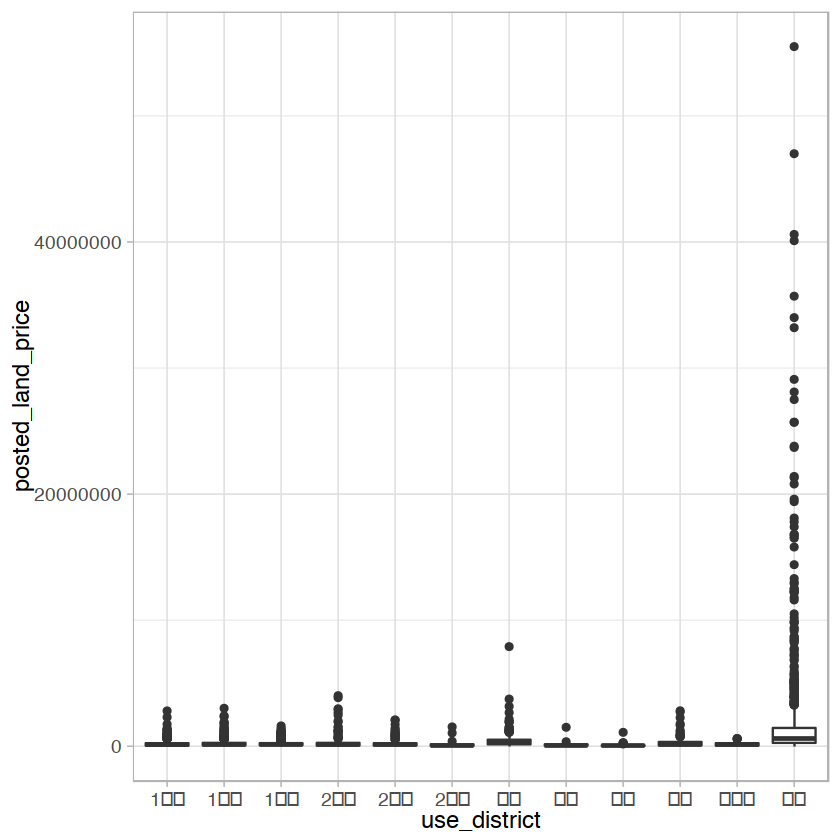

In [21]:
df_lp_kanto %>% 
  ggplot(aes(use_district, posted_land_price)) +
  geom_boxplot()

#### 散布図

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

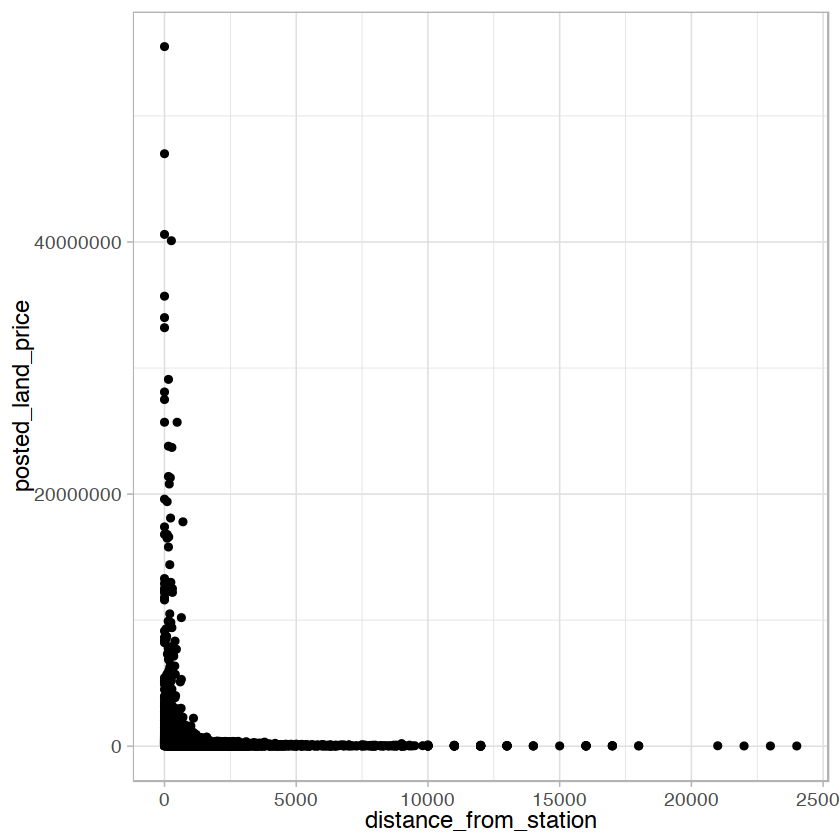

In [22]:
df_lp_kanto %>% 
  ggplot(aes(distance_from_station, posted_land_price)) +
  geom_point()

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.g

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.grap

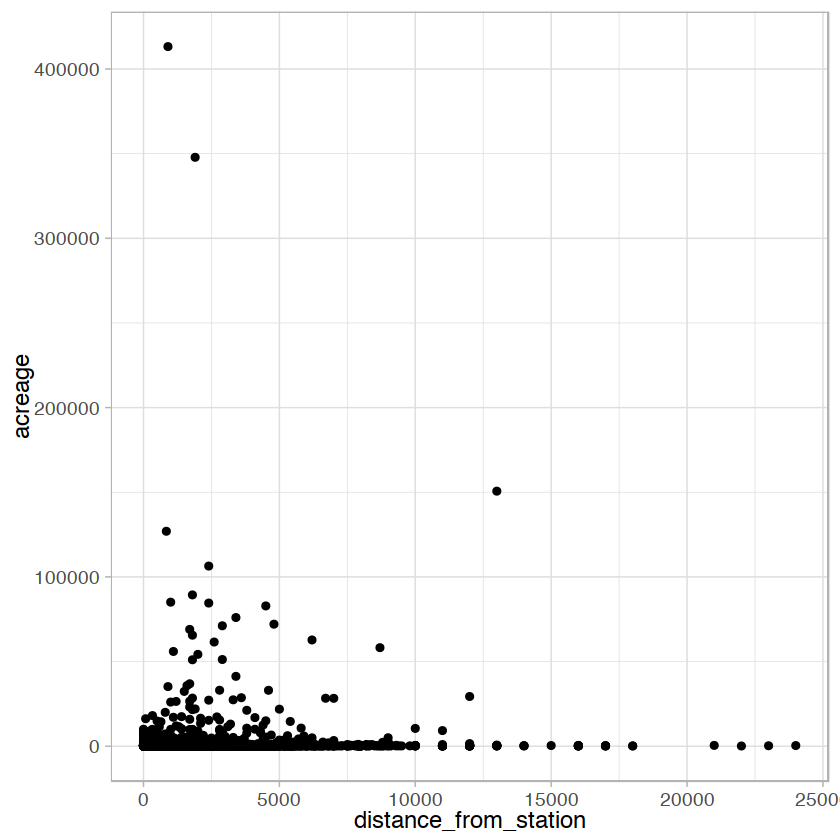

In [24]:
df_lp_kanto %>% 
  ggplot(aes(distance_from_station, acreage)) +
  geom_point()

## 特殊なデータの視覚化

### 時系列データ

時系列データを扱うときは、時間のならびの通りに表示させることが肝心です。周期があるものは分割したり重ねてみると良いでしょう。

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphi

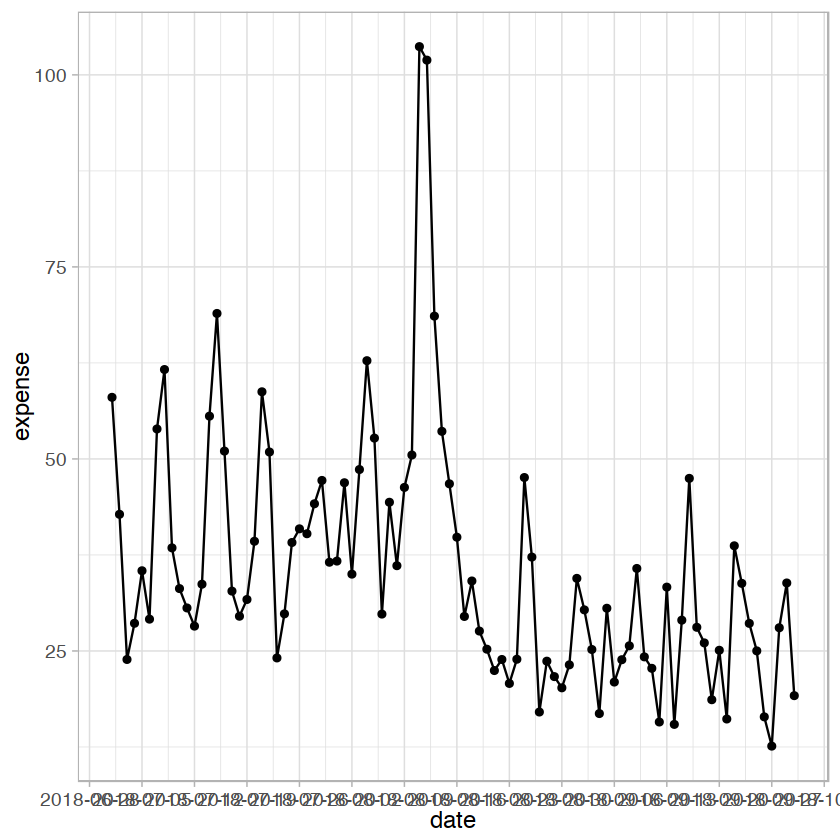

In [25]:
df_beer2018q2 %>% 
  ggplot(aes(date, expense)) +
  geom_point() +
  geom_line() +
  scale_x_date(date_breaks = "7 days")

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, a

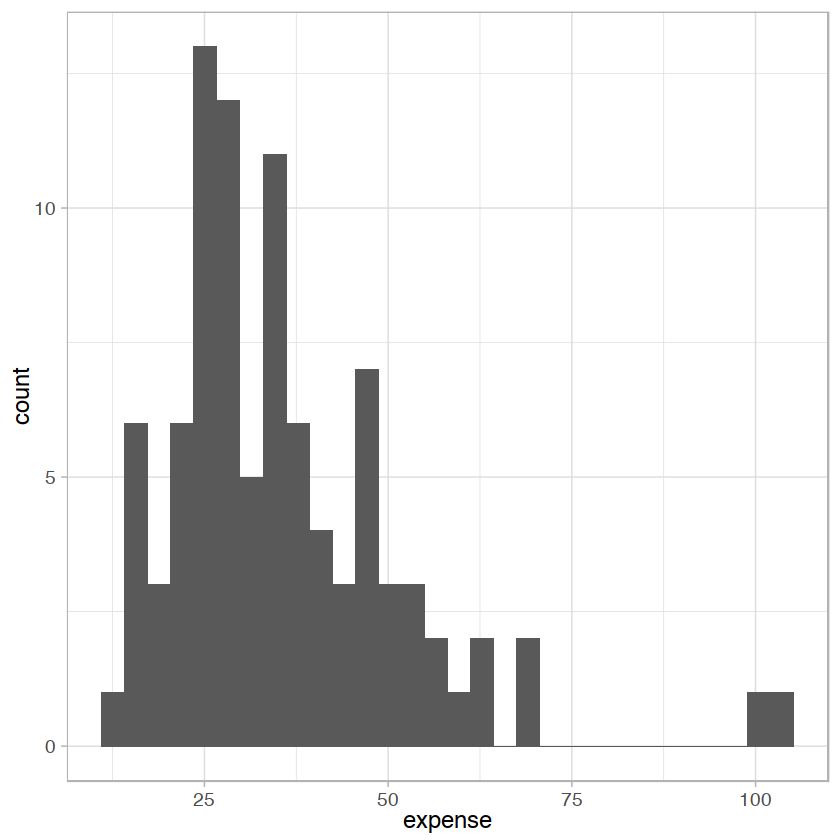

In [26]:
df_beer2018q2 %>% 
  ggplot(aes(expense)) +
  geom_histogram(bins = 30)

### 空間データ

In [ ]:
sf_lp_kanto <- 
  df_lp_kanto %>% 
  select(posted_land_price, .longitude, .latitude) %>% 
  st_as_sf(coords = c(".longitude", ".latitude"), crs = 4326)

ggplot(sf_lp_kanto) +
  geom_sf(aes(color = posted_land_price),
          fill = "transparent", alpha = 0.1, size = 0.5) +
  scale_color_viridis_c()

<!-- ksjのクレジット -->

<!-- アンスコムの例 -->

### 高次元の可視化

3次元の世界に生きる我々は、高次元のデータを直接扱うことに慣れていません。

次元圧縮を行ってからの可視化が効果的です。

#### ヒートマップ

変数間の関係、特に相関や欠損関係がある場合に役立ちます。

#### 散布図行列


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBou

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphi

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call.graphics(C_text

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'IPAexGothic' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphic

rowname,posted_land_price,distance_from_station,acreage,depth_ratio,number_of_floors,number_of_basement_floors,building_coverage,frontage_ratio,floor_area_ratio
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
posted_land_price,NA,-0.12569556,0.008325032,0.035318432,0.43575145,0.54212619,0.219008524,0.05208925,0.475119082
distance_from_station,-0.125695563,NA,0.055539845,-0.058296485,-0.22518578,-0.14142070,-0.223526922,-0.01190656,-0.247763455
acreage,0.008325032,0.05553984,NA,0.007448354,-0.01239013,0.01656375,0.005623651,0.04439868,0.009836352
depth_ratio,0.035318432,-0.05829648,0.007448354,NA,0.09296341,0.04112338,0.275825237,-0.27393794,0.218882108
number_of_floors,0.435751449,-0.22518578,-0.012390130,0.092963407,NA,0.54821812,0.486307961,0.08079867,0.692709498
number_of_basement_floors,0.542126188,-0.14142070,0.016563753,0.041123382,0.54821812,NA,0.276671976,0.04071109,0.495451275
building_coverage,0.219008524,-0.22352692,0.005623651,0.275825237,0.48630796,0.27667198,NA,0.03729320,0.804167426
frontage_ratio,0.052089252,-0.01190656,0.044398678,-0.273937938,0.08079867,0.04071109,0.037293202,NA,0.057795901
floor_area_ratio,0.475119082,-0.24776345,0.009836352,0.218882108,0.69270950,0.49545127,0.804167426,0.05779590,NA


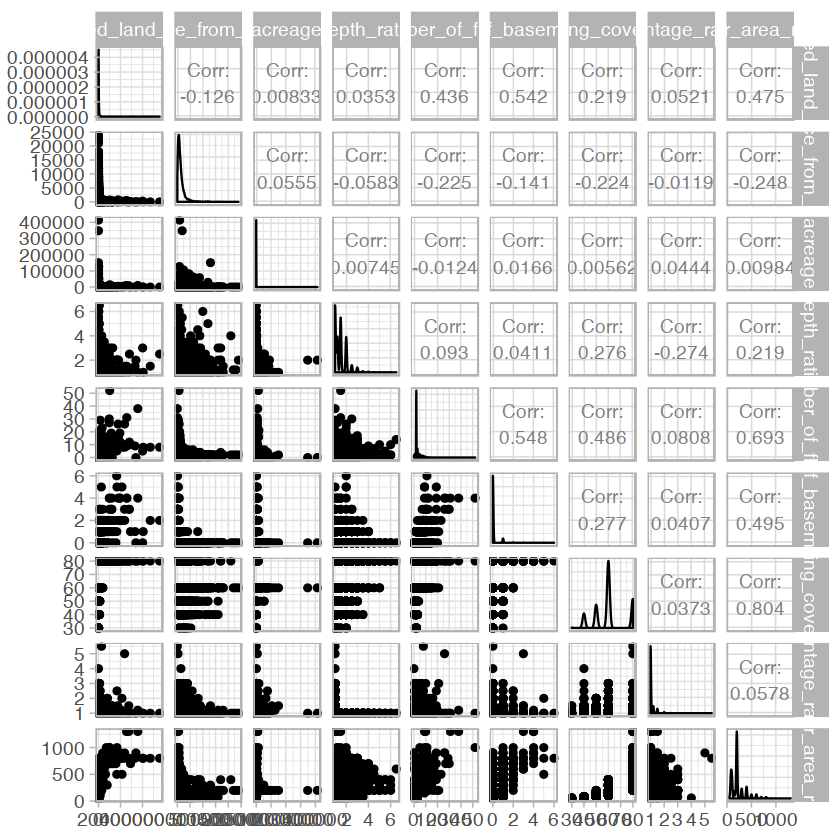

In [28]:
df_is_num %>% 
  GGally::ggpairs()

df_is_num %>% 
  corrr::correlate()

In [ ]:
df_is_num %>% 
  vis_cor()

df_is_log %>% 
  mutate_all(as.numeric) %>% 
  vis_cor()

all.equal(
  df_lp_kanto$attribute_change_building_coverage,
  df_lp_kanto$attribute_change_floor_area_ratio)

#### モデルの利用

効果的な変数の仮説がない場合や、変数の量が多い場合には、EDAの前に木ベースのモデルを適用してみるのも戦略の1つです。これらのモデルでは目的変数に対する説明変数の貢献度として、変数重要度を示すことが可能です。これによりEDAのとっかかりを得ることが可能になるはずです。変数重要度については後の章で解説します。

## まとめ

- モデリング、統計分析を行う前にデータを精査することが大事
    - データの特徴を理解することで次のステップにかける時間を減らす、異常を見逃さない、（意図しない）間違いを見逃さない
- 特に可視化の手法を用いることでデータの集約や関係、パターンを見やすくする

## 関連項目

- 次元削減
- 欠損処理
- 変数重要度

## 参考文献